# Current-based Spiking Neural Network

Install required packages

In [4]:
import numpy as np
import pylab as pl
import random
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import copy

Functions used to plot results

In [82]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [83]:
# exponential filter
def exponential_filter(t, tau):
    return np.exp(-t/tau)

# initialize filter
def initialize_filter(x, tau):
    return [exponential_filter(i, tau) for i in x]

# compute firing rate
def firing_rate(spike_train, filt):
    return np.convolve(spike_train, filt)

Compute and plot firing rate per neuron

In [84]:
def plot_firing_rate():
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 100] = 1

    # initialize exponential filter
    tau = 9
    x = np.linspace(0, tau * 10, 1000)
    y = initialize_filter(x, tau)

    # initialize plots
    plots = N
    pl.subplots(plots, 1)
    pl.suptitle('Firing rate', fontsize=15)
    counter = 1

    # compute input estimate 
    for i in range(1, N+1):

        # compute firing rate
        spike_train = [1 if x==100 else x for x in o[i - 1, :]]
        firingrate = firing_rate(spike_train, y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        counter = counter + 1
        pl.plot(firingrate[0:iterations], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylim(0, 3.5)
        pl.legend()

### Inpute estimate

Compute input estimate one of two ways:

1) Computed input estimate using the derivative $\dot{\hat{x}} = -\hat{x} + \Gamma o$

2) Compute input estimate using a linear readout applied to the spike trains $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$

In [123]:
def plot_estimate():
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 100] = 1

    # initialize exponential filter
    tau = 9
    val = np.linspace(0, tau * 10, 1000)
    y = initialize_filter(val, tau)

    # compute input estimate (by method 2)
    x_est2 = np.zeros(iterations)
    for t in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est2[t] = x_est2[t] + D[0][i] * firingrate[t] 

    # plot input estimates
    pl.subplots(2, 1)
    pl.suptitle('Input estimate $\hat{x}$', fontsize=15)
    pl.subplot(2, 1, 1)
    pl.plot(x_est, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    pl.legend()
    pl.subplot(2, 1, 2)
    pl.plot(x_est2, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    pl.xlabel('time')
    pl.legend()

### Voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\dot{\hat{V}} = -V + \Gamma c -\Gamma^{2} o$

2) Compute voltage estimate using a linear readout applied to the spike trains $V = D_{i}(x - \hat{x})$

In [44]:
def plot_voltage():
    # compute voltage (by method 2)
    voltage2 = np.zeros((N, iterations))
    for t in range(iterations - 1):
        for i in range(N):
            voltage2[i, t] =  np.dot(D[0][i], c[t] - x_est[t])  

    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(8, 4))
    pl.suptitle('Voltage', fontsize=15)
    for i in range(1, N+1):
        pl.subplot(N, 2, counter)
        counter = counter + 1
        pl.plot(voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.subplot(N, 2, counter)
        counter = counter + 1
        pl.plot(voltage2[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.legend()

### Time varying signal

Create time varying signal

In [45]:
def time_varying_signal(c_upp=3):

    # create time-varying signal
    x = c_upp
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 4 * step:iterations] = 1

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

### Run simulation

In [80]:
def run():
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(D, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltages
        dVdt = -voltage[:, t - 1] + D * c[t - 1] - np.dot(D.T * D + np.identity(N) * beta, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]
        
        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

### Plot results

In [130]:
def plot(color, plot_voltage=1):
    if plot_voltage == 0:
        plots = 2
    else:
        plots = N + 2
    pl.subplots(plots, 1, figsize=(8, 10))
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    # plot input and input estimate
    pl.subplot(plots, 1, 1)
    pl.title('Input and input estimate')
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.yticks([])
    pl.xticks([])
    pl.xlim(0, iterations)
    pl.legend()
    
    # plot spike trains
    pl.subplot(plots, 1, 2)
    for i in range(1, N + 1):
        
        values = zero_to_nan(o[i - 1, :] * i)
                
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='Neuron %i' %i)
        pl.yticks([])
        pl.xticks([])
        pl.title('Spike train')
        pl.ylim(0, 100 * N + 100)
        pl.xlim(0, iterations)
        
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    counter = 3
    
    if plot_voltage == 1:
        
        # plot voltage over time
        for i in range(1, N + 1):

            neuron = i + 1

            pl.subplot(plots, 1, counter)
            pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='N%i'%i)
            pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.xlim(0, iterations)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i)
            pl.yticks([])
            pl.xticks([])
            pl.legend()

            counter = counter + 1

## Single-neuron

Initialize parameters

In [99]:
def initialize_params_single(dt, iterations, gamma):
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike train
    o = np.zeros(iterations)

    # voltage
    voltage = np.zeros(iterations)

    # threshold
    T = (gamma**2) / 2

    # spike times
    spike = []
    t_spike = []
    
    return (t, x_est, o, voltage, T, spike, t_spike) 

Create time varying signal

In [100]:
def TVS_single():
    
    # create time-varying signal
    x = 1
    x_t = np.ones(iterations) * x

    step = 100
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 0

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

Run simulation

In [101]:
def run_single():
    for t in range(1, iterations):

        # udpate input estimate
        dxestdt = -x_est[t - 1] + gamma * o[t - 1]
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltage
        dVdt = -voltage[t - 1] + gamma * c[t - 1] - o[t - 1] * (gamma ** 2)
        voltage[t] = voltage[t - 1] + dt * dVdt

        # spike when voltage exceeds threshold
        if voltage[t] > T:
            o[t] = 1/dt

            # save spike times
            spike.append(1)
            t_spike.append(t)

Plot results (input + input estimate, voltage, spikes)

In [92]:
def plot_single():
    plots = 3
    pl.subplots(plots, 1, figsize=(12, 4))

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xticks([])
    pl.legend()

    pl.subplot(plots, 1, 2)
    pl.plot(voltage, 'k')
    pl.xlim(0, iterations)
    pl.ylabel('Voltage')

    pl.subplot(plots, 1, 3)
    pl.scatter(t_spike, spike, c='k')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xlabel('time')

Runs de simulation

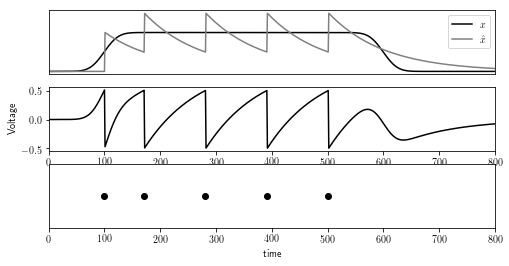

In [104]:
dt = 0.01
iterations = 800
gamma = 1

t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
x,c = TVS_single()
run_single()
plot_single()

## $\textit{N}$-neurons (homogeneous network)

Initialize parameters

In [48]:
def initialize_params_homogeneous(N, dt, iterations, gamma, mu):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    D = np.ones((1, N)) * gamma

    # threshold
    T = [(weight ** 2)/2 + mu/2 for weight in D[0]]

    return (t, x_est, o, voltage, D, T) 

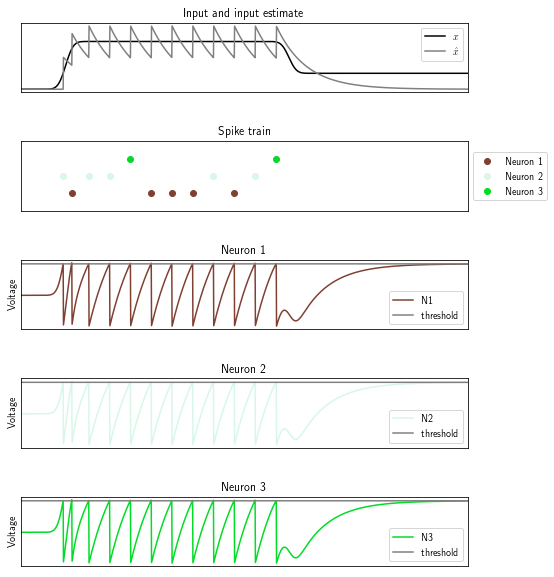

In [131]:
N = 3
dt = 0.01
iterations = 1500
gamma = 2
beta = 0                                                 # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors

t, x_est, o, voltage, D, T = initialize_params_homogeneous(N, dt, iterations, gamma, beta)
x,c = time_varying_signal()
run()
plot(color)

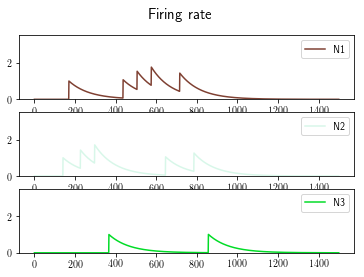

In [132]:
plot_firing_rate()

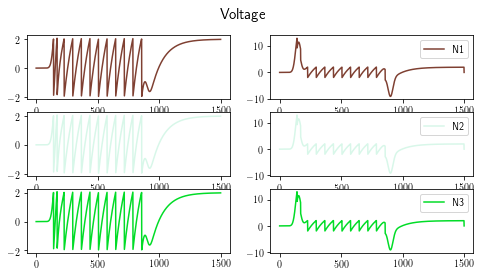

In [133]:
plot_voltage()

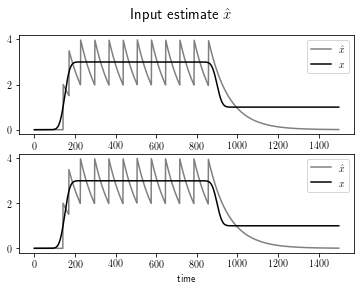

In [134]:
plot_estimate()

## $\textit{N}$-neurons (heterogeneous network)

Initialize parameters

In [29]:
def initialize_params_heterogeneous(N, dt, iterations, mu):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    D = np.random.normal(1/N, 0.5, size=(1,N))

    # threshold
    T = [(weight ** 2)/2 + mu/2 for weight in D[0]]

    return (t, x_est, o, voltage, D, T) 

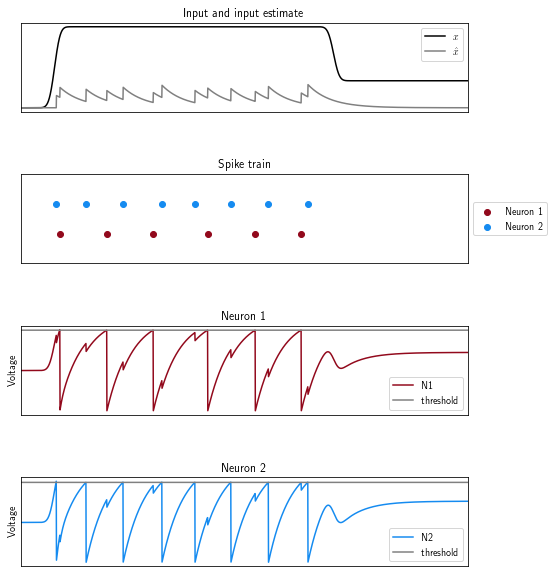

In [138]:
N = 2
dt = 0.01
iterations = 2000
beta = 1.5                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors

t, x_est, o, voltage, D, T = initialize_params_heterogeneous(N, dt, iterations, beta)
x,c = time_varying_signal()
run()
plot(color)

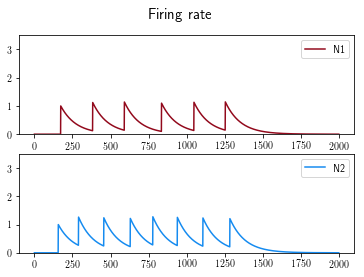

In [139]:
plot_firing_rate()

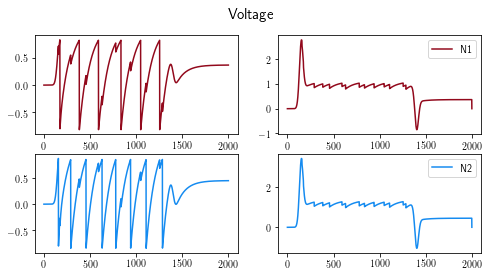

In [140]:
plot_voltage()

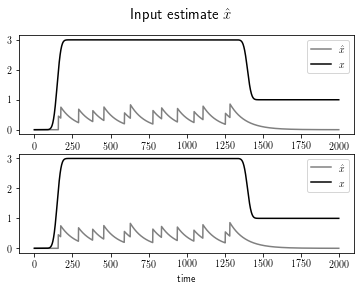

In [141]:
plot_estimate()